In [8]:
import pandas as pd
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score
%matplotlib inline

In [13]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [9]:
X = pd.read_csv('churn_features.csv')
Y = pd.read_csv('churn_labels.csv')

In [27]:
###Eliminate empty string values in totals column
string_bool = df['TotalCharges'] > " "
df = df[string_bool]
len(df)

7032

In [40]:
###Test train split
split_num = int(len(X) * 0.8)

split_df = df[split_num:].copy()
x_test = X[split_num:]
y_test = Y[split_num:]

In [41]:
best_model = load_model('churn_model.h5')
#best_model.summary()

In [42]:
score = best_model.evaluate(x_test, y_test)
score

1407/1407 [==============================] - 0s 96us/step


[0.43153646889102315, 0.80739161348885136]

In [43]:
predictions = best_model.predict(x_test)
new_preds = (predictions > 0.3).astype('int')
new_score = roc_auc_score(y_test, predictions)
print('Acc: {}, ROC_AUC: {}' .format(score[1], new_score))

Acc: 0.807391613489, ROC_AUC: 0.84046548275


In [44]:
split_df['predictions'] = new_preds
split_df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,predictions
5634,2320-JRSDE,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,19.90,19.9,Yes,1
5635,2087-QAREY,Female,0,Yes,No,22,Yes,No,DSL,No,...,No,No,No,Month-to-month,Yes,Mailed check,54.70,1178.75,No,0
5636,0601-WZHJF,Male,0,Yes,No,14,No,No phone service,DSL,No,...,No,Yes,Yes,Month-to-month,No,Electronic check,46.35,667.7,Yes,1
5637,4423-JWZJN,Male,0,Yes,Yes,64,Yes,Yes,Fiber optic,No,...,No,No,Yes,One year,No,Credit card (automatic),90.25,5629.15,No,0
5638,5143-WMWOG,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.95,19.95,Yes,0
5639,6490-FGZAT,Male,0,No,No,6,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.65,109.3,No,0
5640,5393-RXQSZ,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,Month-to-month,No,Electronic check,79.60,79.6,Yes,1
5641,7452-FOLON,Male,0,No,Yes,39,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),25.45,958.45,No,0
5642,2320-TZRRH,Female,0,No,No,20,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,No,Mailed check,19.50,403.15,No,0
5643,0231-LXVAP,Male,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,Month-to-month,Yes,Electronic check,75.90,75.9,Yes,1


In [46]:
split_df.to_csv('churn_with_preds.csv', index = False)

In [56]:
def get_cf(threshold):
    new_preds = (predictions > threshold).astype('int')
    new_score = roc_auc_score(y_test, new_preds)
    cf = confusion_matrix(y_test, new_preds)
    return cf
cf = get_cf(.25)
cf

array([[721, 305],
       [ 74, 307]])

In [57]:
#Return total cost tor replace total lost
def get_cost(cf):
    total_lost = sum(cf[1])
    new_cost_replace = 50
    current_cost_replace = 10
    rate_return = .6
    current_contacted = cf[0][1] + cf[1][1]
    current_replace_cost = current_contacted * current_cost_replace
    current_retained = int(cf[1][1] * rate_return)
    new_replace = total_lost - current_retained
    new_replace_cost = new_replace * new_cost_replace
    total_cost = new_replace_cost + current_replace_cost
    return total_cost

cost = get_cost(cf)
cost

15970

In [45]:
savings = (381*50)-cost
savings

3190

<h4>Industry Assumptions</h4>
<ul>
    <li>10 dollars to to keep customer</li>
    <li>50 dollars to replace customer</li>
    <li>%60 continue if contacted</li>
</ul>

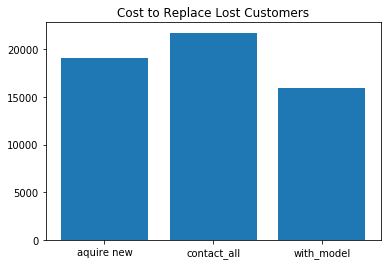

In [63]:
aquire_new = get_cost(get_cf(1))
contact_all = get_cost(get_cf(0))
with_model = get_cost(get_cf(.418))
plt.bar(['aquire new','contact_all','with_model'], [aquire_new, contact_all, with_model])
plt.title('Cost to Replace Lost Customers');

In [25]:
def get_cf(threshold):
    new_preds = (predictions > threshold).astype('int')
    cf = confusion_matrix(y_test, new_preds)
    return cf
cf = get_cf(.25)
cf

array([[721, 305],
       [ 74, 307]])

In [58]:
scores = []
for i in range(1,800):
    i = i*.001
    new_preds = (predictions > i).astype('int')
    new_score = roc_auc_score(y_test, new_preds)
    scores.append(new_score)

0.757133428497


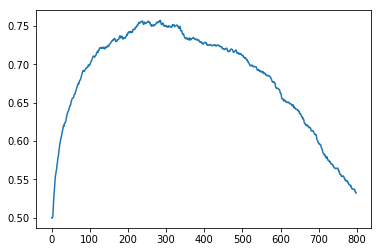

In [59]:
scores = np.array(scores)
print(scores.max())
plt.plot(scores);

In [65]:
#Return 
costs = []
def get_costs():
    min_cost = 100000
    for i in range(1,1000):
        i = i*.001
        cf = get_cf(i)
        t_cost = get_cost(cf)
        if t_cost < min_cost:
            min_cost = t_cost
        costs.append(t_cost)
        
get_costs()

In [62]:
min(costs)

15760

In [98]:
split_df = df[split_num:].copy()
split_df['prediction'] = predictions
split_df['cutoff .3'] = new_preds
output_df = split_df[['customerID', 'Churn', 'prediction', 'cutoff .3']]
output_df.head(35)

,customerID,Churn,prediction,cutoff .3
5634,2320-JRSDE,Yes,0.342533,1
5635,2087-QAREY,No,0.269989,0
5636,0601-WZHJF,Yes,0.485579,1
5637,4423-JWZJN,No,0.149310,0
5638,5143-WMWOG,Yes,0.287758,0
5639,6490-FGZAT,No,0.177875,0
5640,5393-RXQSZ,Yes,0.659012,1
5641,7452-FOLON,No,0.027164,0
5642,2320-TZRRH,No,0.039580,0
5643,0231-LXVAP,Yes,0.598981,1
